# Anomaly detection

This is an attempt to perform [anomaly detection][] on contract data. In particular, many prices in the contract data seem to reflect _daily_ (or perhaps even weekly or monthly) rates rather than _hourly_ rates, and this is an attempt to find them (though we might find other anomalies in the process too).

Note that unlike other notebooks in this repository, this one requires Anaconda and runs on Python 3.6.

[anomaly detection]: https://www.coursera.org/learn/machine-learning/lecture/V9MNG/problem-motivation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

%matplotlib inline

## Load hourly price data

In [2]:
hourly_prices = pd.read_csv('../data/hourly_prices.csv', index_col=False, thousands=',', usecols=[
    'Labor Category',
    'CurrentYearPricing',
    'Education',
    'MinExpAct',
    'Schedule',
    'CONTRACT .',
    'COMPANY NAME',
])

hourly_prices.rename(columns={
    'Labor Category': 'name',
    'CurrentYearPricing': 'price',
    'Education': 'edu',
    'MinExpAct': 'minxp',
    'Schedule': 'schedule',
    'CONTRACT .': 'contract',
    'COMPANY NAME': 'company',
}, inplace=True)

hourly_prices.dropna(axis=0, how='any', inplace=True)

## Bin experience into buckets

For reasons that will make more sense soon, we're going to define "buckets" of minimum experience:

* Bucket 0: 0-4 minimum years of experience
* Bucket 1: 5-9 minimum years of experience
* Bucket 2: 10-14 minimum years of experience
* Bucket 3: 15-19 minimum years of experience
* Bucket 4: 20+ minimum years of experience

In [3]:
MAX_XP = 20.0

XP_BUCKET_SIZE = 5

NUM_XP_BUCKETS = int(MAX_XP / XP_BUCKET_SIZE + 1)

hourly_prices['xp_bucket'] = (hourly_prices.minxp.clip(upper=MAX_XP) / XP_BUCKET_SIZE).astype(int)

Let's see what our data looks like so far:

In [4]:
hourly_prices[:10]

,name,edu,minxp,company,contract,schedule,price,xp_bucket
0,Project Manager,Bachelors,8.0,"SSG-Advisors, LLC",GS-10F-0274S,MOBIS,1013.38,1
1,Program Coordinator,Bachelors,1.0,University Of Maryland University College,GS-10F-0357N,MOBIS,992.56,0
3,Administrative Support,Bachelors,1.0,University Of Maryland University College,GS-10F-0357N,MOBIS,981.44,0
4,Associate,Masters,6.0,"SSG-Advisors, LLC",GS-10F-0274S,MOBIS,990.82,1
9,"AcquCenter Customer Site Installation, Additio...",None,0.0,"Noblis, Inc.",GS-00F-096DA,Consolidated,952.14,0
10,AcquTrak Remote Access Archival Functions Onlu...,None,0.0,"Noblis, Inc.",GS-00F-096DA,Consolidated,952.14,0
11,AcquTrak Remote Access Pre-Source Selection Ph...,None,0.0,"Noblis, Inc.",GS-00F-096DA,Consolidated,952.14,0
12,AcquTrak Remote Access Source Selection/Post A...,None,0.0,"Noblis, Inc.",GS-00F-096DA,Consolidated,952.14,0
13,Producer,High School,7.0,"Ambient Light, LLC",GS-00F-212DA,Consolidated,941.58,1
14,Video Editor,High School,7.0,"Ambient Light, LLC",GS-00F-212DA,Consolidated,910.19,1


## Make it easy to slice and dice the data

Here we'll add a `filtr` function (the name `filter` is taken) to make it easy to filter through the data any way we want.

In [5]:
NONE = 'None'
HIGH_SCHOOL = 'High School'
ASSOCIATES = 'Associates'
BACHELORS = 'Bachelors'
MASTERS = 'Masters'
PHD = 'Ph.D.'

EDU_LEVELS = [NONE, HIGH_SCHOOL, ASSOCIATES, BACHELORS, MASTERS, PHD]

def filtr(edu=None, xp_bucket=None, minxp=None, schedule=None):
    r = hourly_prices
    if edu is not None:
        r = r[r.edu == edu]
        if r.empty:
            raise ValueError(f"invalid edu: {edu}")
    if xp_bucket is not None:
        if xp_bucket < 0 or xp_bucket >= NUM_XP_BUCKETS:
            raise ValueError(f"invalid xp_bucket: {xp_bucket}")
        r = r[r.xp_bucket == xp_bucket]
    if minxp is not None:
        r = r[r.minxp >= minxp]
    if schedule is not None:
        r = r[r.schedule == schedule]
        if r.empty:
            raise ValueError(f"invalid schedule: {schedule}")
    return r


## Transform price data

Our existing price distribution is kind of lopsided because most labor categories have low prices.  As per Andrew Ng's suggestion in his [lecture on choosing what features to use](https://www.coursera.org/learn/machine-learning/lecture/LSpXm/choosing-what-features-to-use), we'll transform the price data to have a more normal distribution.

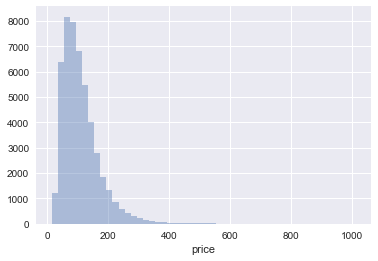

In [6]:
sns.distplot(hourly_prices.price, kde=False)

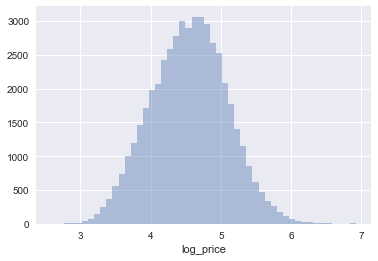

In [7]:
hourly_prices['log_price'] = np.log(hourly_prices.price)

sns.distplot(hourly_prices.log_price, kde=False)

## Define density estimation parameters

Because prices are clearly influenced by the level of education and number of years of experience, we're going to calculate our mean and variance based on each education level / experience bucket combination. Whether something is an anomaly will then depend on what its price is relative to the particular education level / experience bucket combination it's in.

We'll do this using a pandas [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/advanced.html).

In [8]:
edu_xp_index = pd.MultiIndex.from_product([EDU_LEVELS, range(NUM_XP_BUCKETS)], names=['edu', 'xp_bucket'])

In [9]:
def edu_xp_agg(func):
    return list(edu_xp_index.map(lambda x: filtr(edu=x[0], xp_bucket=x[1]).log_price.agg(func)))

In [10]:
edu_xp_aggs = pd.DataFrame(
    list(zip(edu_xp_agg('mean'), edu_xp_agg('std'))),
    index=edu_xp_index, columns=['mean', 'std']
)

Here's what our `edu_xp_aggs` DataFrame looks like now.  Note that only the shape is really important: the numbers won't actually mean much, since they reflect the mean/variance of our transformed prices. 

In [11]:
edu_xp_aggs[:10]

mean       std
edu         xp_bucket                    
None        0          3.995196  0.642604
            1          4.280357  0.422386
            2          4.575483  0.313358
            3          4.850301  0.408797
            4          5.072629  0.317072
High School 0          3.866920  0.354101
            1          4.215916  0.375981
            2          4.494704  0.394335
            3          4.741732  0.414377
            4          4.815409  0.360243

## Define Gaussian primitives

This is taken from Ng's [lecture on the Gaussian Distribution](https://www.coursera.org/learn/machine-learning/lecture/ZYAyC/gaussian-distribution).

In [12]:
def gaussian_prob(value, std, mean):
    return (1 / ((np.sqrt(2 * np.pi)) * std)) * np.exp(-np.square(value - mean) / (2 * np.square(std)))

def plot_gaussian(std, mean, start=-1, stop=1, step=0.1):
    x = np.arange(start, stop + step, step)
    return plt.plot(x, gaussian_prob(x, std, mean))

Just to make sure our gaussian works, let's draw it.

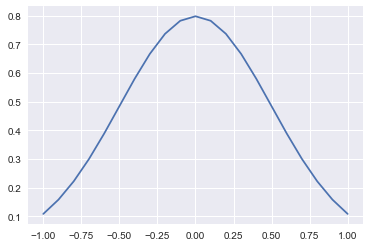

In [13]:
plot_gaussian(0.5, 0)

## Find anomalous prices

We'll combine our density estimation parameters with our hourly price data via [DataFrame.merge](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and use that to get probabilities for every price, as per the [lecture on the density estimation algorithm](https://www.coursera.org/learn/machine-learning/lecture/C8IJp/algorithm).

In [14]:
def probabilities():
    merged = hourly_prices.merge(edu_xp_aggs, left_on=['edu', 'xp_bucket'], right_index=True, how='left')
    return gaussian_prob(hourly_prices.log_price, merged['std'], merged['mean'])

In [15]:
epsilon = 0.01

hourly_prices[probabilities() < epsilon][:1]

,name,edu,minxp,company,contract,schedule,price,xp_bucket,log_price
0,Project Manager,Bachelors,8.0,"SSG-Advisors, LLC",GS-10F-0274S,MOBIS,1013.38,1,6.921047
